In [1]:
import os
import json

import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import requests
import json
import random
import base64

In [2]:
def read_json_file(_path):
    with open(_path) as json_file:
        return json.load(json_file)

In [3]:
captions = read_json_file("./../datasets/DeepFashion/MultiModal/captions.json")

In [4]:
data = [{"id": k, "description": v, "path": f"./../datasets/DeepFashion/MultiModal/images/{k}"} for k, v in captions.items()]

In [5]:
OPENROUTER_API_KEY = "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"
OPENROUTER_MODEL_NAME = "google/gemini-2.0-flash-exp:free"

In [6]:
SYSTEM_PROMPT = """
SYSTEM:
You are an accurate, conservative computer-vision + fashion-attribute extractor.
Given an image (provided as a visual input) and a short caption describing the image, your job is to detect garment items of type "shirt" and "pants" only, describe each detected garment, and return the exact JSON array described below. Be precise with bounding boxes and brief in descriptions.

Important rules:
- Output **only** valid JSON (no surrounding text, no backticks, no explanations).
- The JSON must be a top-level array of objects. Each object must contain exactly these keys: "type", "description", "bbox".
- "type" must be either the string "shirt" or "pants".
- "description" must be a concise textual description (6–18 words) of the garment (color, pattern, sleeve length or pant cut if visible, and any other clear attribute).
- "bbox" must be either:
  - absolute pixel coordinates: `[x1, y1, x2, y2]` (integers), **if** the message includes `image_width` and `image_height` fields; OR
  - normalized coordinates in [0.0, 1.0]: `[x1, y1, x2, y2]` (floats with 3 decimal places) **if** image dimensions are NOT provided.
- Coordinates must follow image convention: origin (0,0) at top-left, x to right, y down, and x2>x1, y2>y1.
- Do not invent garments not visually present. If a detected garment is ambiguous (e.g., partially occluded), include it only if you are reasonably certain. Do not output confidence fields — only items you are confident about.
- If no shirts or pants are detected, output an empty array: `[]`.
- Do not output duplicate or near-duplicate boxes; merge highly overlapping detections into one.
- Keep each "description" factual and avoid subjective claims (e.g., don't guess brand or exact material unless obvious).

You will receive:
1) the image (attached as the visual input to the model)
2) a short textual caption describing the image
3) optionally: image metadata in JSON with keys: image_width (int), image_height (int)

Task:
Detect garment items of type "shirt" or "pants" visible in the image. For each detected garment return an object with:
- "type": "shirt" or "pants"
- "description": a concise factual description (6–18 words) including visible color, pattern, sleeve length or pant cut when discernible
- "bbox": [x1, y1, x2, y2] as described in the system prompt (pixels if image_width/height provided, otherwise normalized floats with 3 decimal places)

INPUT:
Caption: "{{caption_text}}"
(Optional) Image metadata JSON: {{ "image_width": IMAGE_WIDTH, "image_height": IMAGE_HEIGHT }}

OUTPUT:
Return only a JSON array like:
[
  {
    "type": "shirt",
    "description": "white short-sleeve cotton t-shirt with small logo",
    "bbox": [120, 80, 420, 400]
  },
  {
    "type": "pants",
    "description": "dark blue slim-fit jeans, ankle length",
    "bbox": [110, 390, 430, 920]
  }
]

Notes:
- If image metadata JSON is provided, produce pixel bbox integers.
- If metadata is not provided, produce normalized coordinates (three decimals).
- If you are unsure about sleeve length or exact color, choose the most visually plausible concise description and avoid guessing details that cannot be seen.

"""

USER_PROMPT = """
USER:
Caption: {caption_text}
(Optional) Image metadata JSON: {image_metadata}
"""

In [7]:
def get_response(system_prompt, user_text, user_image):
    resp = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {OPENROUTER_API_KEY}",
            "Content-Type": "application/json",
        },
        data=json.dumps({
        "model": OPENROUTER_MODEL_NAME,
        "messages": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": [
                {"type": "text", "text": user_text},
                {"type": "image_url", "image_url": {"url": user_image}}
            ]},
        ],
        "temperature": 0,
        })
    )

    return resp

In [8]:
d = random.choice(data)

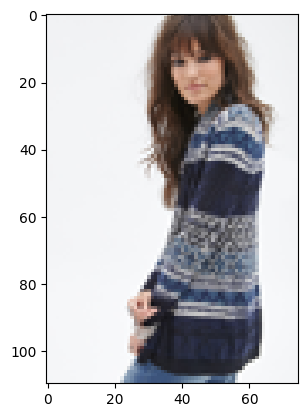

In [9]:
from PIL import Image

img = Image.open(d["path"]).convert("RGB")
img = img.resize((img.width // 10, img.height // 10))
plt.imshow(img)
plt.show()
(w, h) = img.size
img_enc = base64.b64encode(open(d["path"], "rb").read()).decode("utf-8")

In [10]:
resp = get_response(
    SYSTEM_PROMPT,
    USER_PROMPT.format(caption_text=d["description"], image_metadata={"image_width": w, "image_height": h}),
    f"data:image/jpeg;base64,{img_enc}"
)

In [11]:
print(resp)

<Response [429]>


In [12]:
resp = resp.json()

In [13]:
result = resp["choices"][0]["message"]["content"]

KeyError: 'choices'

In [ ]:
result = result.replace("```json", "").replace("```", "")
result = json.loads(result)

In [ ]:
result

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img)
for c in result:
    bb = c["bbox"]
    plt.plot((bb[0], bb[0]), (bb[1], bb[3]))
    plt.plot((bb[2], bb[2]), (bb[1], bb[3]))
    plt.plot((bb[0], bb[2]), (bb[1], bb[1]))
    plt.plot((bb[0], bb[2]), (bb[3], bb[3]))
plt.show()